In [23]:
from typing import Set, Callable

from Ballot import Ballot
from CandidateModel import CandidateModel
from DefaultConfigOptions import *
from Election import Election
from ElectionResult import ElectionResult
from HeadToHeadElection import HeadToHeadElection
from InstantRunoffElection import InstantRunoffElection
from NDPopulation import NDPopulation
import pickle

In [24]:
class ElectionConstructor:
    def __init__(self, constructor: Callable[[List[Ballot], Set[Candidate]], Election], name: str):
        self.constructor = constructor
        self.name = name

    def run(self, ballots: List[Ballot], candidates: Set[Candidate]) -> ElectionResult:
        e = self.constructor(ballots, candidates)
        return e.result()

def construct_irv(ballots: List[Ballot], candidates: Set[Candidate]):
    return InstantRunoffElection(ballots, candidates)

def construct_h2h(ballots: List[Ballot], candidates: Set[Candidate]):
    return HeadToHeadElection(ballots, candidates)

In [25]:
class Sample:
    def __init__(self, opponents: List[Candidate], candidate: Candidate):
        self.opponents = opponents.copy()
        self.candidate = candidate

In [26]:
def create_population(ideology_dim: int) -> (CandidateModel, NDPopulation):
    population_means = np.zeros(shape=(ideology_dim,))
    population_stddev = np.ones(shape=(ideology_dim,))
    pop = NDPopulation(population_means, population_stddev)
    return pop

In [27]:
class Stats:
    def __init__(self):
        self.winner_distance = 0
        self.results: List[Candidate] = []
        self.candidates = []
    def reset(self):
        self.winner_distance = 0
        self.results = []
        self.candidates = []
    def update(self, winner: Candidate, candidates: List[Candidate]):
        self.winner_distance += winner.ideology.distance_from_o()
        self.results.append(winner)
        self.candidates.append(candidates)
    def print(self, label: str):
        print("%15s %5d " %
               (label,
               len(self.results)), end="")

        print("%5.2f" % (self.winner_distance / len(self.results)))

In [28]:
class ProcessResult:
    def __init__(self, process: ElectionConstructor, dim: int, stats: Stats):
        self.process = process
        self.dim = dim
        self.stats = stats

    def print(self):
        self.stats.print("%12s - %dD" % (self.process.name, self.dim))

In [29]:
def generate_candidates(population: NDPopulation, n_candidates: int) -> List[Candidate]:
    candidates = []
    for i in range(n_candidates):
        ideology = population.unit_sample_voter().ideology
        c = Candidate("r-" + str(i), Independents, ideology, 0)
        candidates += [c]
    return candidates

def run_process(processes: List[ElectionConstructor], dim: int, samples: int) -> List[ProcessResult]:
    results = {}
    for p in processes:
        results[p] = ProcessResult(p, dim, Stats())

    population = create_population(dim)
    for i in range(samples):
        print("running sample %d" % i)
        voters = population.generate_unit_voters(1000)
        candidates = generate_candidates(population, 6)
        for process in processes:
            ballots = [Ballot(v, candidates, unit_election_config) for v in voters]
            r = process.run(ballots, set(candidates))
            results[process].stats.update(r.winner(), candidates)

    return list(results.values())

In [30]:
def create_random_results():
    results = []
    processes = [
        ElectionConstructor(constructor=construct_irv, name="Hare"),
        ElectionConstructor(constructor=construct_h2h, name="Minimax")
    ]

    for dim in [1,2,3,4]:
        results += run_process(processes, dim, 1000)

    for r in results:
        r.print()

    with open("random_results.p", "wb") as f:
        pickle.dump(results, f)

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results():
    with open("random_results.p", "rb") as f:
        results = pickle.load(f)

    nrows = 2
    ncols = 3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))
    fig.suptitle("Distance From Origin for Winner With Random Candidates", color="black", fontsize=22)
    fig.set_facecolor("white")

    count = 0
    irv_results = [r for r in results if r.process.name == "Hare"]
    h2h_results = [r for r in results if r.process.name == "Minimax"]

    for ir, hr in zip(irv_results, h2h_results):
        assert(ir.dim == hr.dim)
        row = count // ncols
        col = count % ncols
        count += 1

        axis = axes[row][col]
        axis.tick_params(axis='x', colors="black")
        axis.tick_params(axis='y', colors="black")
        axis.set_xlim([0, 2])

        iv = [ w.ideology.distance_from_o() for w in ir.stats.results]
        hv = [ w.ideology.distance_from_o() for w in hr.stats.results]

        axis.hist([iv, hv], bins=30, label=[ir.process.name, hr.process.name])
        axis.set_title("Dimensionality: %d" % ir.dim, color="black")

        axis.legend()

    plt.savefig("foo.png")

In [36]:
def print_stats():
    with open("random_results.p", "rb") as f:
        results = pickle.load(f)

    def min_distance(cc: List[Candidate]) -> float:
        x: float = np.min([c.ideology.distance_from_o() for c in cc])
        return x

    irv_results: List[ProcessResult] = [r for r in results if r.process.name == "Hare"]
    h2h_results: List[ProcessResult] = [r for r in results if r.process.name == "Minimax"]

    print("Results for candidates drawn randomly from the population")
    print("Dimensionality  Best       Hare       Minimax")
    for ir, hr in zip(irv_results, h2h_results):
        dim = ir.dim
        irv_winner_distance = [w.ideology.distance_from_o() for w in ir.stats.results]
        h2h_winner_distance = [w.ideology.distance_from_o() for w in hr.stats.results]
        best_candidate = [min_distance(cc) for cc in hr.stats.candidates]

        print("%d             " % dim, end = "")
        print("%5.2f       " % np.mean(best_candidate), end="")
        print("%5.2f       " % np.mean(irv_winner_distance), end ="")
        print("%5.2f       " % np.mean(h2h_winner_distance))



In [42]:
#create_random_results()

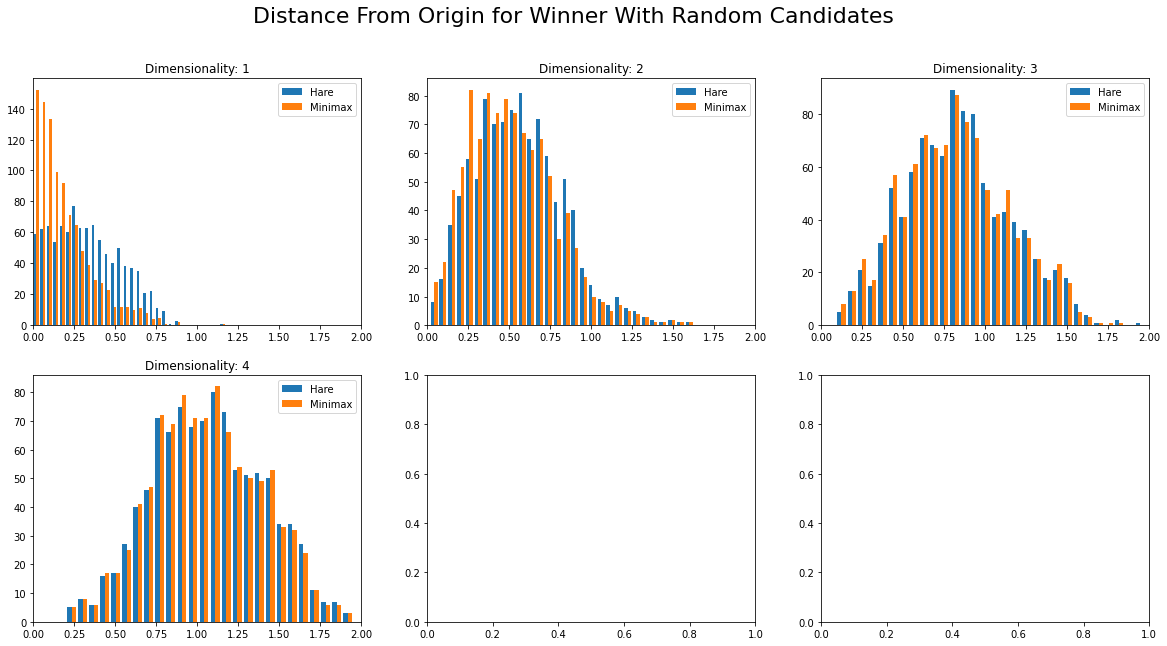

In [43]:
plot_results()

In [44]:
print_stats()


Results for candidates drawn randomly from the population
Dimensionality  Best       Hare       Minimax
1              0.19        0.33        0.19       
2              0.51        0.56        0.51       
3              0.82        0.84        0.82       
4              1.06        1.07        1.06       
